<a href="https://colab.research.google.com/github/surabhipandey18/Deep-Learning/blob/main/efficientnet_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt

2025-09-11 03:13:29.894005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757560410.091697      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757560410.147872      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
def preprocess(image, label):
  image = tf.expand_dims(image, -1)
  image = tf.image.resize(image, (224, 224))
  image = tf.tile(image, [1, 1, 3])
  image = tf.keras.applications.efficientnet.preprocess_input(image)
  label = tf.one_hot(label, depth=10)
  return image, label

ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
                   .batch(64) \
                   .prefetch(tf.data.AUTOTUNE)
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
                   .batch(64) \
                   .prefetch(tf.data.AUTOTUNE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1757560423.308923      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757560423.309578      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


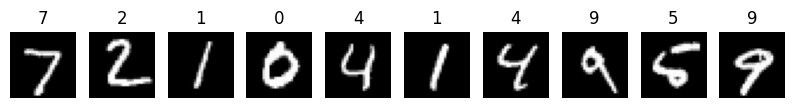

In [ ]:
#see the images first 10
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title(y_test[i])
    plt.axis("off")
plt.show()

In [ ]:
#import the base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-20:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

efficientnet_model = Model(inputs=base_model.input, outputs=predictions)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
plot_model(efficientnet_model, to_file=f'efficientnet_model_architecture.png', show_shapes=True, show_layer_names=True)

efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

with tf.device('/GPU:0'):
    history = efficientnet_model.fit(ds_train, epochs=5, validation_data=ds_test)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 369s 307ms/step - accuracy: 0.9858 - loss: 0.0489 - val_accuracy: 0.9793 - val_loss: 0.0607
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 252s 268ms/step - accuracy: 0.9914 - loss: 0.0282 - val_accuracy: 0.9864 - val_loss: 0.0441
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 250s 267ms/step - accuracy: 0.9924 - loss: 0.0258 - val_accuracy: 0.9923 - val_loss: 0.0281
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 250s 267ms/step - accuracy: 0.9937 - loss: 0.0182 - val_accuracy: 0.9924 - val_loss: 0.0308
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 251s 268ms/step - accuracy: 0.9945 - loss: 0.0175 - val_accuracy: 0.9920 - val_loss: 0.0304


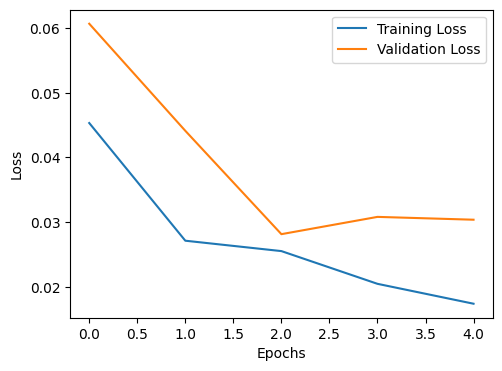

In [ ]:
#figure of different optimizers working
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

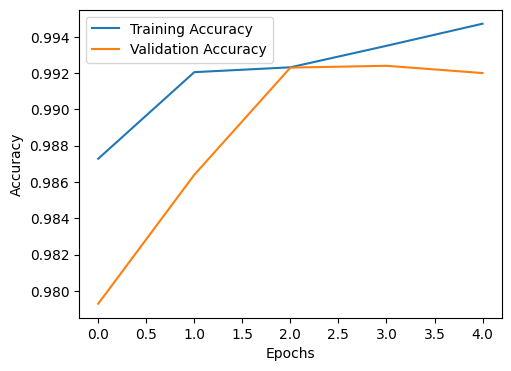

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print(efficientnet_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,710,573 (17.97 MB)

 Trainable params: 4,668,550 (17.81 MB)

 Non-trainable params: 42,023 (164.16 KB)

None


In [ ]:
print(f" Val Accuracy: {history.history['val_accuracy'][-1]:.4f}, Val Loss: {history.history['val_loss'][-1]:.4f}")

NameError: name 'history' is not defined

In [ ]:
import joblib
joblib.dump(efficientnet_model, 'efficientnet_model.pkl')

['efficientnet_model.pkl']